Part 5 - Classification
=========================

**Exercise 1**


Now here is some more data. But the labels were lost which trial belongs to which condition. Your job is now to use models that you fitted on the first part of the data on each condition seperately to find out which trial belongs to which condition.

You can use as many or few neurons as you want and as complex or simple models as you want. Keep in mind that not all cells will have the same amount of information about the conditions.

Save your prediction to a file.


In the first part you can choose a portion of the trial time or a lower resolution. Also you can (but do not have to) partition the data into training and test sets.

If you haven't already, get the data from <a href="https://www.dropbox.com/sh/p0x1jrl6xqui2fb/AAD2e7QJo7QGMaL6t-NnsDf0a">here</a>. You will need one or more of the `Spikes_Group_Condition_A`, `Spikes_Group_Condition_B` and  `Spikes_Test` files.

In [2]:
import ni

data_A = ni.Data('data/Spikes_Group_Condition_A.pkl')
data_B = ni.Data('data/Spikes_Group_Condition_B.pkl')
data = ni.data.data.merge([data_A,data_B],dim='Condition')

data = data.time(500,3500).reduce_resolution(2)             # solution

data_test = ni.Data('data/Spikes_Test.pkl').time(500,3500).reduce_resolution(2) # solution

perm = random.permutation(range(data.nr_trials))

print perm[:(data.nr_trials/2)]
training_data = data.trial(perm[:(data.nr_trials/2)])
print perm[(data.nr_trials/2):]
test_data = data.trial(perm[(data.nr_trials/2):])


ni/data/data.py:296: Warning: Lost 3881 spikes in the process of reducing resolution.
  warn("Lost "+str(int(before_spikes - after_spikes))+" spikes in the process of reducing resolution.", Warning)
ni/data/data.py:296: Warning: Lost 1269 spikes in the process of reducing resolution.
  warn("Lost "+str(int(before_spikes - after_spikes))+" spikes in the process of reducing resolution.", Warning)


[60 18 59 36 24 38 56 45 48 22 39 11 58 26 14  5 33 30 49 23 12  4 55 27 65
 53  0 43 46 40 42 15 21]
[19 28 32 57 31  9  6 37 51 62 20 10 29  3 47  8 52 25 44 41 61 63 35  7 13
 17 54 16 50  2  1 64 34]


You have a lot of freedom on how you want to approach this problem. Try to document your work for your presentations.

The next cell contains the standard model configuration and creates a model for each 

In [3]:
# Here is some example configuration for models
models = [
                [ni.model.ip.Model({
                    'cell': cell, 
                    'name':'Model for Cell '+str(cell)+' in Condition '+str(condition),
                    'constant': True,
                    'rate': True,
                        'knots_rate': 20,
                        'adaptive_rate': True,
                        'adaptive_rate_exponent': 2,
                        'adaptive_rate_smooth_width': 20,
                    'autohistory': True,
                        'history_length': 100,
                        'knot_number': 3,
                    'autohistory_2d': False,
                    'crosshistory': True,
                    #'backend':'elasticnet',
                    'mask': [True],
                    'custom_kernels': [],
                    'custom_components': []
                }) for cell in range(data.nr_cells)] 
            for condition in range(data.nr_conditions)]


Models for condition 0: [<ni.model.ip.Model object at 0x284eb50>, <ni.model.ip.Model object at 0x284ebd0>, <ni.model.ip.Model object at 0x284eb10>, <ni.model.ip.Model object at 0x6811750>, <ni.model.ip.Model object at 0x6811990>, <ni.model.ip.Model object at 0x6811b10>, <ni.model.ip.Model object at 0x6811cd0>]
Models for condition 1: [<ni.model.ip.Model object at 0x6811d50>, <ni.model.ip.Model object at 0x6811dd0>, <ni.model.ip.Model object at 0x6811e50>, <ni.model.ip.Model object at 0x6811ed0>, <ni.model.ip.Model object at 0x6811f50>, <ni.model.ip.Model object at 0x6811fd0>, <ni.model.ip.Model object at 0x3c78f50>]


Fitting the models can again take a while. If you are impatient and just want to test your code, use .reduce_resolution() on the data in the first cell.

fitting Model for Cell 0 in Condition 0 ...
fitting Model for Cell 1 in Condition 0 ...
fitting Model for Cell 2 in Condition 0 ...
fitting Model for Cell 3 in Condition 0 ...
fitting Model for Cell 4 in Condition 0 ...
fitting Model for Cell 5 in Condition 0 ...
fitting Model for Cell 6 in Condition 0 ...
fitting Model for Cell 0 in Condition 1 ...
fitting Model for Cell 1 in Condition 1 ...
fitting Model for Cell 2 in Condition 1 ...
fitting Model for Cell 3 in Condition 1 ...
fitting Model for Cell 4 in Condition 1 ...
fitting Model for Cell 5 in Condition 1 ...
fitting Model for Cell 6 in Condition 1 ...


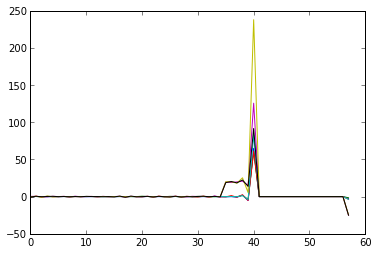

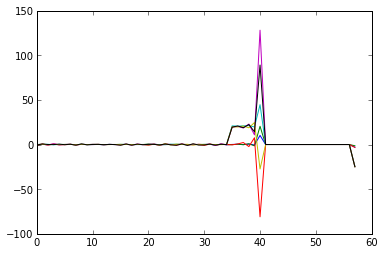

In [4]:
fitted_models = []

for condition in range(data.nr_conditions):
    fitted_models.append([])
    for cell in range(data.nr_cells):
        model = models[condition][cell]
        print 'fitting',model.name,'...'
        fm = model.fit(training_data.condition(condition))
        fitted_models[condition].append(fm)

Here we test which cells help in classifying and which are useless.



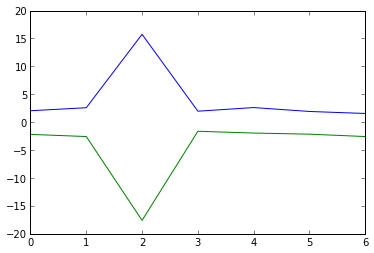

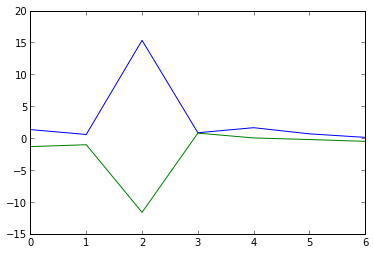

In [9]:
# [solution_cell]

other_condition = 1
plot(np.array([f.compare(training_data.condition(0))['LogLikelihood'] for f in fitted_models[0]]).transpose() - np.array([f.compare(training_data.condition(0))['LogLikelihood'] for f in fitted_models[other_condition]]).transpose())
plot(np.array([f.compare(training_data.condition(other_condition))['LogLikelihood'] for f in fitted_models[0]]).transpose() - np.array([f.compare(training_data.condition(other_condition))['LogLikelihood'] for f in fitted_models[other_condition]]).transpose())
figure()
plot(np.array([f.compare(test_data.condition(0))['LogLikelihood'] for f in fitted_models[0]]).transpose() - np.array([f.compare(test_data.condition(0))['LogLikelihood'] for f in fitted_models[other_condition]]).transpose())
plot(np.array([f.compare(test_data.condition(other_condition))['LogLikelihood'] for f in fitted_models[0]]).transpose() - np.array([f.compare(test_data.condition(other_condition))['LogLikelihood'] for f in fitted_models[other_condition]]).transpose())



 Since we now know that cell 3 is not usefull, we can exclude it from our final model: 

In [12]:
# [solution_cell]

weights_1 = [1,1,1,0,1,1,1]   # solution
print weights_1               # solution

weights_0 = [1,1,1,0,1,1,1]   # solution
print weights_0               # solution

[1, 1, 1, 0, 1, 1, 1]
[1, 1, 1, 0, 1, 1, 1]


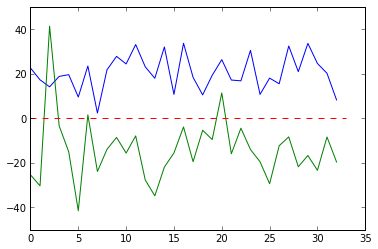

In [13]:
# [solution_cell]

likelihood_ratios = np.zeros((2,test_data.nr_trials))
for t in range(test_data.nr_trials):
    dat = test_data.condition(0).trial(t)
    likelihood_ratios[0,t] = ((weights_0*np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[0]])).sum()-
        (weights_0*np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[1]])).sum())

for t in range(test_data.nr_trials):
    dat = test_data.condition(1).trial(t)
    likelihood_ratios[1,t] = ((weights_1*np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[0]])).sum()-
        (weights_1*np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[1]])).sum())
    
plot(likelihood_ratios.transpose())
plot([0,test_data.nr_trials],[0,0],'r--')

In `data_test` there is some more data. But the labels were lost which trial belongs to which condition. Your job is now to use models that you fitted on the first part of the data on each condition seperately to find out which trial belongs to which condition.

You can use as many or few neurons as you want and as complex or simple models as you want. Keep in mind that not all cells will have the same amount of information about the conditions.

Save your prediction to a file.

In [37]:
prediction = []
for t in range(data_test.nr_trials):
    dat = data_test.condition(0).trial(t)
    if (np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[0]]).sum() >
        np.array([f.compare(dat)['LogLikelihood'] for f in fitted_models[1]]).sum()):
        prediction.append(1)
    else:
        prediction.append(0)
    
print prediction

[0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1]


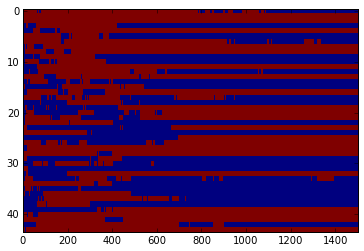

In [58]:
prediction = []
for t in range(data_test.nr_trials):
    dat = data_test.condition(0).trial(t)
    prediction.append((np.array([f.compare(dat)['llf'].cumsum() for f in fitted_models[0]]).sum(0) >
        np.array([f.compare(dat)['llf'].cumsum() for f in fitted_models[1]]).sum(0)))
prediction = 1*np.array(prediction)
imshow(prediction,aspect='auto',interpolation='nearest')

In [59]:
print "Final Prediction"
print prediction[:,-1]

[0 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 1 1 1 0 1]


**About the file format:** You should use a text file format that makes it obvious which trial you suppose to be which condition (0 or 1). Below are two examples, one using the *javascript object notation* JSON, the other *comma separated values* CSV, each with their appropriate file extension. Both formats can be opened in a texteditor.

Change your group name and save your prediction.

In [68]:
group_name = 'group'

In [69]:
# File save example
# either use json
import json

with open(group_name+'_prediction.json', 'w') as f:
    f.write(json.dumps(prediction.tolist()))

In [70]:
# or use comma separated values

numpy.savetxt(group_name+'_prediction.csv', prediction, fmt='%d', delimiter=',')

That's it for part 5! And the whole course
============================================

(Now you can start on your presentations)